In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

def append_ext(fn):
    return fn+".jpg"

traindf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Part3_GroundTruth.csv',dtype=str)
testdf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Part3_GroundTruth.csv',dtype=str)
traindf['image_id']=traindf['image_id'].apply(append_ext)
testdf['image_id']=testdf['image_id'].apply(append_ext)

In [2]:
tr_label=[0]*traindf.shape[0]
for i in range(traindf.shape[0]):
    if traindf['melanoma'][i] == '1.0':
        tr_label[i]='1'
    else:
        tr_label[i]='0'

traindf['label']=tr_label    

#create a label
tt_label=[0]*testdf.shape[0]
for i in range(testdf.shape[0]):
    if testdf['melanoma'][i] == '1.0':
        tt_label[i]='1'
    else:
        tt_label[i]='0'

testdf['label']=tt_label

In [3]:
X = traindf.loc[:,'image_id']
y = traindf.loc[:,'label']

from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X, y, 
                                                  test_size = 0.25, 
                                                  random_state = 27, 
                                                  stratify=y)

In [4]:
df_train = pd.DataFrame(columns=['image_id','label'])
df_train['image_id'] = train_x
df_train['label'] = train_y
print(df_train)

# Test df
df_val= pd.DataFrame(columns=['image_id','label'])
df_val['image_id'] = val_x
df_val['label'] = val_y
print(df_val)

              image_id label
1864  ISIC_0014658.jpg     0
1324  ISIC_0012986.jpg     0
1078  ISIC_0012182.jpg     0
336   ISIC_0000408.jpg     0
1851  ISIC_0014630.jpg     0
...                ...   ...
1723  ISIC_0014174.jpg     0
384   ISIC_0000479.jpg     0
1055  ISIC_0012102.jpg     0
658   ISIC_0009963.jpg     0
1996  ISIC_0015233.jpg     0

[1500 rows x 2 columns]
              image_id label
1805  ISIC_0014526.jpg     0
248   ISIC_0000294.jpg     1
1222  ISIC_0012682.jpg     0
1722  ISIC_0014173.jpg     1
201   ISIC_0000229.jpg     0
...                ...   ...
312   ISIC_0000372.jpg     0
459   ISIC_0001100.jpg     1
1271  ISIC_0012813.jpg     0
1756  ISIC_0014325.jpg     1
1778  ISIC_0014430.jpg     0

[500 rows x 2 columns]


In [5]:
# IMG_SIZE = 224 #B0
# IMG_SIZE = 240 #B1
# IMG_SIZE = 260 #B2
IMG_SIZE = 300 #B3
# IMG_SIZE = 380 #B4
# IMG_SIZE = 456 #B5
# IMG_SIZE = 528 #B6
# IMG_SIZE = 600 #B7

In [6]:
train_datagen=ImageDataGenerator(rotation_range=5,  # rotation
                                 width_shift_range=0.2,  # horizontal shift
                                 zoom_range=0.2,  # zoom
                                 horizontal_flip=True,  # horizontal flip
                                 brightness_range=[0.2,0.8] # brightness
                                )  


train_generator=train_datagen.flow_from_dataframe(dataframe=df_train,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

valid_datagen=ImageDataGenerator()
valid_generator=valid_datagen.flow_from_dataframe(dataframe=df_val,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

test_datagen=ImageDataGenerator()#rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=testdf,
                                                directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Data\\',
                                                x_col='image_id',
                                                y_col=None,
                                                batch_size=30,
                                                seed=40,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(IMG_SIZE,IMG_SIZE)
                                               )

Found 1500 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 600 validated image filenames.


In [7]:
from tensorflow.keras.applications import EfficientNetB3
# Create the base model from the pre-trained model EfficientNet
base_model = EfficientNetB3(include_top=False, weights="imagenet")

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

NUM_CLASSES=1
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = inputs
model = EfficientNetB3(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 300, 300, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 300, 300, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization_1[0][0]            
_______________________________________________________________________________________

In [9]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size

model.fit(train_generator,
          epochs=5,
          validation_data=valid_generator,
          verbose=1
         )

Epoch 1/5
47/47 [==============================] - 712s 15s/step - loss: 0.7374 - accuracy: 0.1774 - val_loss: 0.6163 - val_accuracy: 0.1880
Epoch 2/5
47/47 [==============================] - 667s 14s/step - loss: 0.6740 - accuracy: 0.1810 - val_loss: 0.4291 - val_accuracy: 0.1880
Epoch 3/5
47/47 [==============================] - 652s 14s/step - loss: 0.6725 - accuracy: 0.1781 - val_loss: 0.4666 - val_accuracy: 0.1880
Epoch 4/5
47/47 [==============================] - 658s 14s/step - loss: 0.6482 - accuracy: 0.1914 - val_loss: 0.4916 - val_accuracy: 0.1880
Epoch 5/5
47/47 [==============================] - 633s 14s/step - loss: 0.6805 - accuracy: 0.1780 - val_loss: 0.5003 - val_accuracy: 0.1880


In [10]:
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

15/15 [==============================] - 115s 8s/step - loss: 0.5127 - accuracy: 0.1917


[0.5127279758453369, 0.19166666269302368]

In [11]:
test_generator.reset()

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
pred=model.predict(test_generator,
                   steps=STEP_SIZE_TEST,
                   verbose=1)

20/20 [==============================] - 327s 16s/step


In [12]:
labels_pred=np.where(pred > 0.5, 1, 0)

C:\Users\rafag\anaconda3\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


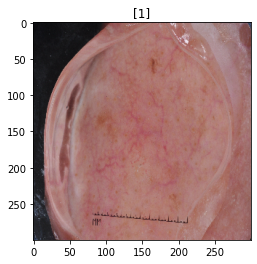

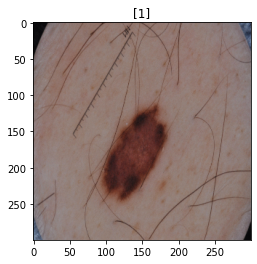

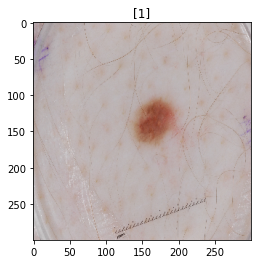

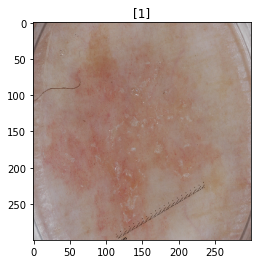

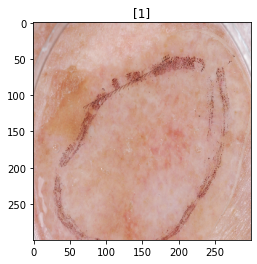

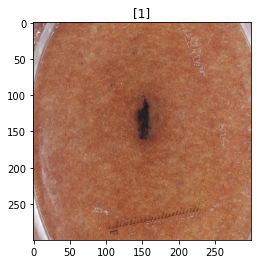

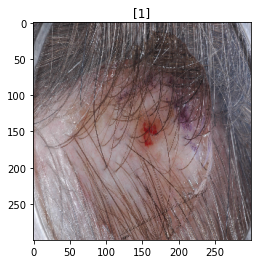

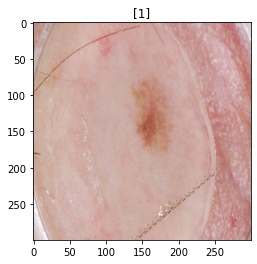

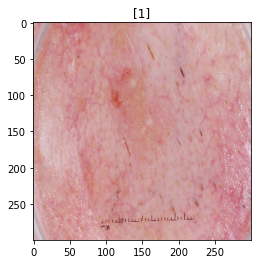

In [13]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
x = test_generator.next() #this unpacks the ImageDataGenerator which is composed by x(image) and y(label). In the case of test, there are not labels
for i in range(9):
    image = x[i]
    plt.title(labels_pred[i])
    plt.imshow(image.astype(np.uint8))
    plt.show()

In [14]:
print('Predictions')
print('Melanoma:' + str(np.count_nonzero(labels_pred == 1)))
print('Non-Melanoma:' + str(np.count_nonzero(labels_pred == 0)))

print('\nGround Truth')
print('Melanoma:' + str(np.count_nonzero(testdf['label'] == '1')))
print('Non-Melanoma:' + str(np.count_nonzero(testdf['label'] == '0')))

Predictions
Melanoma:600
Non-Melanoma:0

Ground Truth
Melanoma:117
Non-Melanoma:483


In [15]:
model.save("EfficientNetB3_softmax.h5")
print("Saved model to disk")

# load model
# model = load_model('model.h5')
# model.summary()

Saved model to disk


In [16]:
import sklearn
confusion_matrix=sklearn.metrics.confusion_matrix(testdf['label'].astype(int).to_numpy(), labels_pred)

print('Confusion Matrix: \n' + str(confusion_matrix))

Confusion Matrix: 
[[  0 483]
 [  0 117]]


AUC Score: 0.5


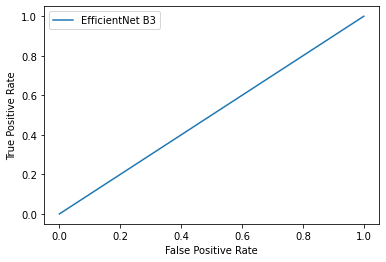

In [18]:
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

fpr, tpr, threshold = roc_curve(testdf['label'].astype(int).to_numpy(),labels_pred)
roc_auc = metrics.auc(fpr, tpr)
print('AUC Score: ' + str(roc_auc))

# plot the roc curve for the model
pyplot.plot(fpr, tpr, linestyle='-', label='EfficientNet B3')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()